In [126]:
import pydub
import numpy as np
import matplotlib.pyplot as plt
import os

from dtaidistance import dtw
from scipy.signal import argrelextrema, find_peaks
from scipy.spatial.distance import cosine

import pandas as pd
import seaborn as sns

In [127]:
SOUND_FRAME_RATE=40000

## Playground

In [128]:
def get_audio_sample(sound_addr):
    sound = pydub.AudioSegment.from_file(sound_addr, format=sound_addr.split(".")[-1])
    sound = sound.set_frame_rate(SOUND_FRAME_RATE)
    samples = sound.get_array_of_samples()
    audio_sample = np.array(samples)
    return audio_sample

In [129]:
def get_audio_prompt(sound_addr):
    sound = pydub.AudioSegment.from_file(sound_addr, format=sound_addr.split(".")[-1])
    sound = sound.set_frame_rate(SOUND_FRAME_RATE)
    samples = sound.get_array_of_samples()
    audio_sample = np.array(samples)[int(sound.frame_rate*(4/3)**2*8):]
    return audio_sample

## Scoring Procedure

In [130]:
def master_scoring_procedure(participant_response, answer_addr):
    participant_sample = get_audio_sample(participant_response)
    answer_sample = get_audio_prompt(answer_addr)
    
    participant_signal = np.where(participant_sample > 0.1 * np.max(participant_sample), 1.0, 0)
    participant_nonzero_indices = np.nonzero(participant_signal)[0]
    participant_signal = participant_signal[participant_nonzero_indices[0]:participant_nonzero_indices[-1] + 1]
    
    answer_signal = np.where(answer_sample[:int(44100 * 4/3 * 8)] > 800, 1, 0)
    answer_nonzero_indices = np.nonzero(answer_signal)[0]
    answer_signal = answer_signal[answer_nonzero_indices[0]:answer_nonzero_indices[-1] + 1]
    
    participant_downsample = downsample_signal(participant_signal, 100)
    true_sample_downsample = downsample_signal(answer_signal, 100)
    return cosine(participant_downsample, true_sample_downsample)

In [131]:
all_participants = os.listdir("./participant_data/")
scoring_basis_files = [
    f"../generated_beats/compiled_mp3/{file_name}"
    for file_name in os.listdir("../generated_beats/compiled_mp3/")
    if "practice" not in file_name
]
full_scoring_data = {
    "trial_source": [],
    "signal_similarities": [],
    "participant_ID": []
}
for participant in all_participants[:]:
    if participant == "22-J-13-SUR": continue
    participant_response_addresses = {
        file_name.split(".")[0]: f"./participant_data/{participant}/{file_name}"
        for file_name in os.listdir(f"./participant_data/{participant}/")
    }
    scoring_file_addresses = {
        "night_1_trial_1": scoring_basis_files[9],
        "night_1_trial_2": scoring_basis_files[10],
        "night_1_trial_3": scoring_basis_files[11],
        "night_2_trial_1": scoring_basis_files[12],
        "night_2_trial_2": scoring_basis_files[13],
        "night_2_trial_3": scoring_basis_files[14],
        "night_3_trial_1": scoring_basis_files[15],
        "night_3_trial_2": scoring_basis_files[16],
        "night_3_trial_3": scoring_basis_files[17],
        "morning_2_trial_1": scoring_basis_files[3],
        "morning_2_trial_2": scoring_basis_files[4],
        "morning_2_trial_3": scoring_basis_files[5],
        "morning_3_trial_1": scoring_basis_files[6],
        "morning_3_trial_2": scoring_basis_files[7],
        "morning_3_trial_3": scoring_basis_files[8]
    }
    if "morning_1" in list(participant_response_addresses.keys())[0]:
        participant_response_addresses.update(
            {
                "morning_2_trial_1": participant_response_addresses.pop("morning_1_trial_1"),
                "morning_2_trial_2": participant_response_addresses.pop("morning_1_trial_2"),
                "morning_2_trial_3": participant_response_addresses.pop("morning_1_trial_3"),
                "morning_3_trial_1": participant_response_addresses["morning_2_trial_1"],
                "morning_3_trial_2": participant_response_addresses["morning_2_trial_2"],
                "morning_3_trial_3": participant_response_addresses["morning_2_trial_3"]
            }
        )
        scoring_file_addresses.update(
            {
                "morning_2_trial_1": scoring_basis_files[0],
                "morning_2_trial_2": scoring_basis_files[1],
                "morning_2_trial_3": scoring_basis_files[2],
                "morning_3_trial_1": scoring_basis_files[3],
                "morning_3_trial_2": scoring_basis_files[4],
                "morning_3_trial_3": scoring_basis_files[5]
            }
        )
    for trial_source in participant_response_addresses.keys():
        full_scoring_data["participant_ID"].append(participant)
        full_scoring_data["trial_source"].append(trial_source)
        full_scoring_data["signal_similarities"].append(
            master_scoring_procedure(
                participant_response_addresses[trial_source],
                scoring_file_addresses[trial_source]
            )
        )

Text(0, 0.5, 'Cosine Similarity of Prompt and Participant Response')

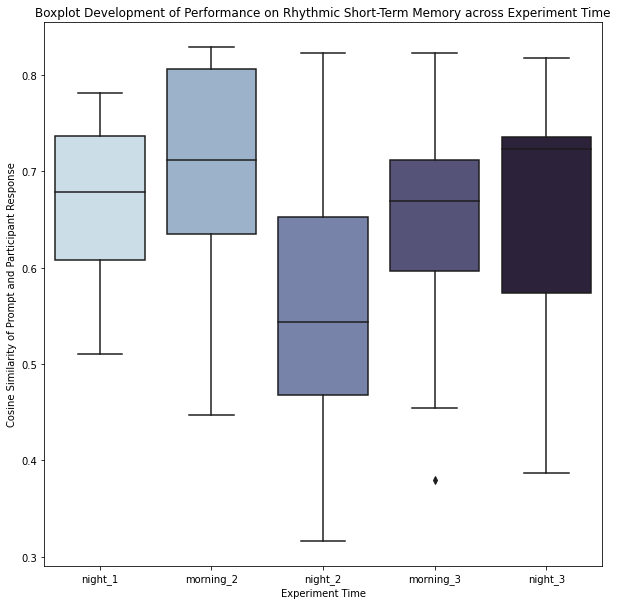

In [132]:
everyone_score = pd.DataFrame(data=full_scoring_data)
everyone_score["trial_source_abbrev"] = everyone_score["trial_source"].apply(lambda x: x.split("_trial")[0])
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(
    data=everyone_score,
    x="trial_source_abbrev",
    y="signal_similarities",
    order=["night_1", "morning_2", "night_2", "morning_3", "night_3"],
    palette="ch:s=.25,rot=-.25"
)
plt.title("Boxplot Development of Performance on Rhythmic Short-Term Memory across Experiment Time")
plt.xlabel("Experiment Time")
plt.ylabel("Cosine Similarity of Prompt and Participant Response")